# Spatial and Time Series Analysis of San Francisco Crimes
This dataset was downloaded from [DataSF](https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry) at the beginning of March 2018.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('Police_Department_Incidents.csv')

##  Data Exploration
Let's do some basic inspection of the data first

In [2]:
df.shape

(2184187, 13)

In [3]:
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


We can see that ``X`` and ``Y`` are actually the Longitude and Latitude, which are also in the column of ``Location``.

In [4]:
df.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
PdId            int64
dtype: object

We should check if there is any missing values in the data frame.

In [5]:
df.isnull().sum()

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
dtype: int64

Fortunately, there is only one NAN in the column of ``PdDistrict``. I'll just fill it with the most common value (mode).

In [6]:
df.PdDistrict.fillna(df.PdDistrict.mode()[0], inplace=True)

Let's take look at the distribution of the incidents across the values in some columns.

**Category**

In [7]:
df.Category.value_counts()

LARCENY/THEFT                  471559
OTHER OFFENSES                 305721
NON-CRIMINAL                   234800
ASSAULT                        191685
VEHICLE THEFT                  125641
DRUG/NARCOTIC                  118654
VANDALISM                      114219
WARRANTS                       100270
BURGLARY                        90136
SUSPICIOUS OCC                  79338
MISSING PERSON                  64083
ROBBERY                         55169
FRAUD                           40942
SECONDARY CODES                 25401
FORGERY/COUNTERFEITING          22901
WEAPON LAWS                     21866
TRESPASS                        19110
PROSTITUTION                    16664
STOLEN PROPERTY                 11740
SEX OFFENSES, FORCIBLE          11495
DISORDERLY CONDUCT               9970
DRUNKENNESS                      9769
RECOVERED VEHICLE                8716
DRIVING UNDER THE INFLUENCE      5614
KIDNAPPING                       5289
RUNAWAY                          4384
LIQUOR LAWS 

``LARCENY/THEFT`` incidents are the most, which is not very surprising. If we also count ``VEHICLE THEFT``, there are about 600k theft incidents, or 27% of all the incidents.

**DayOfWeek**

In [8]:
df.DayOfWeek.value_counts()

Friday       333109
Wednesday    319498
Saturday     316019
Thursday     311705
Tuesday      310975
Monday       302352
Sunday       290529
Name: DayOfWeek, dtype: int64

Interestingly, Friday is the day with the most incidents.

**PdDistrict**

A list and a map of the 10 Police stations can be found [here](http://sanfranciscopolice.org/police-district-maps)

In [9]:
df.PdDistrict.value_counts()

SOUTHERN      393972
MISSION       295709
NORTHERN      268786
CENTRAL       222209
BAYVIEW       218359
INGLESIDE     191725
TENDERLOIN    189846
TARAVAL       164595
PARK          123799
RICHMOND      115187
Name: PdDistrict, dtype: int64

Based on the map, ``SOUTHERN``, ``MISSION``, ``NORTHERN``, ``CENTRAL`` stations basically cover the north-eastern part of SF. As we will visulaize the data later, these are indeed the most dangerous areas.

**Resolution**

In [10]:
df.Resolution.value_counts()

NONE                                      1366451
ARREST, BOOKED                             517582
ARREST, CITED                              154789
LOCATED                                     34463
PSYCHOPATHIC CASE                           29185
UNFOUNDED                                   23617
JUVENILE BOOKED                             13974
COMPLAINANT REFUSES TO PROSECUTE             8089
DISTRICT ATTORNEY REFUSES TO PROSECUTE       7955
NOT PROSECUTED                               7720
JUVENILE CITED                               6586
PROSECUTED BY OUTSIDE AGENCY                 5070
EXCEPTIONAL CLEARANCE                        4239
JUVENILE ADMONISHED                          3004
JUVENILE DIVERTED                             694
CLEARED-CONTACT JUVENILE FOR MORE INFO        684
PROSECUTED FOR LESSER OFFENSE                  85
Name: Resolution, dtype: int64

Over half of the cases are not resolved.

How about the variation across different months? There should be some kind of seasonal effect.

In [11]:
# Convert "Date" to a form of "yyyy-mm-dd" and create another column "Month"
df.Date = df.Date.map(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1])
df['Month'] = df.Date.map(lambda x: int(x.split('-')[1]))

# Count the number of incidents in each month
# Since the 2018 is not over yet, we only use the 2003~2017 data
monthly_count = df.Month[df.Date < '2018'].value_counts()
monthly_count

10    190410
8     187357
3     186806
1     185539
5     184073
9     183376
7     181797
4     179502
11    174937
6     174727
12    170606
2     168652
Name: Month, dtype: int64

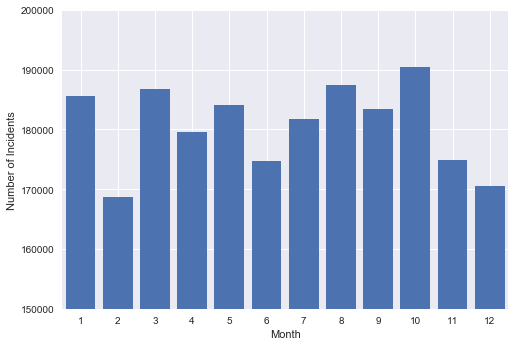

In [12]:
# make a bar plot
fig = plt.figure()
plt.bar(sorted(monthly_count.index), monthly_count.values[np.argsort(monthly_count.index)])
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xlim((0.5,12.5))
plt.ylim((150000,200000))
plt.xticks( np.arange(1,13) )
plt.show()

I expected that the holiday season, November and December, would have the least incidents. The result shows there are indeed less incidents in this two months, but they are not the last two.

How about the variation across different times of a day?

In [13]:
# Convert the time to floating point numbers between 0 and 24
df['Time_float'] = df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

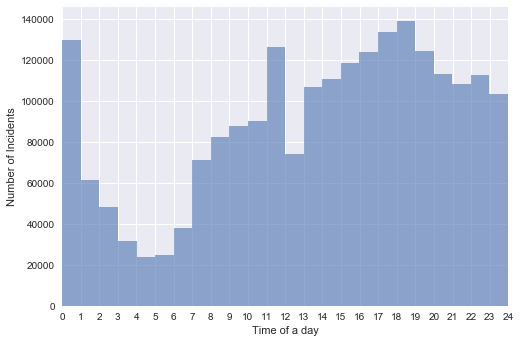

In [14]:
# make a histogram
fig = plt.figure()
plt.hist(df['Time_float'], bins=24, alpha = 0.6)
plt.xlabel('Time of a day')
plt.ylabel('Number of Incidents')
plt.xlim((0.0, 24))
plt.xticks( np.arange(0,25) )
plt.show()

Overall there are more crimes in the afternoon and evening than in the morning. And of course, there are much less crimes during the sleeping hours.

##  Spatial Distribution
Let's visualize the distribution of all the incidents using the longitude and latitude information

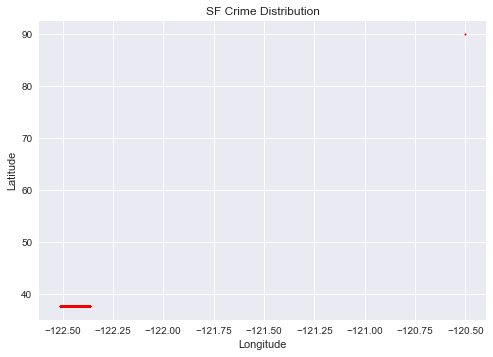

In [15]:
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df.X, df.Y, s = 0.5, c = 'r')
plt.show()

Ahh, so there is one point at (-120.5, 90)! This is obviously a mistake made by the police department. Let's just remove this data point for better visualization.

In [16]:
df_new = df[df['Y'] < 80]

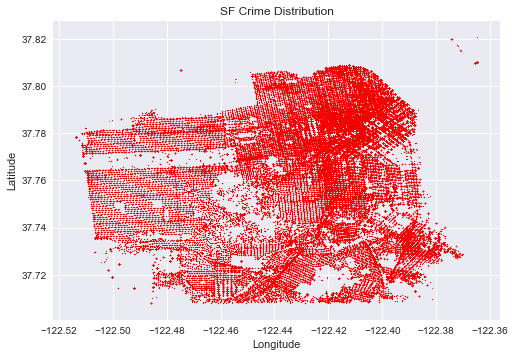

In [17]:
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df_new.X, df_new.Y, s = 0.5, c = 'r')
plt.show()

We can see there are more crimes in the north-eastern part of SF. I wonder if this is always the case over the last 15 years. Let's see if the distribution has any sigificant change. In order to reduce the computation time, I'll just plot the data of January each year. To better understand the spatial distribution, this time I will overlay contours on the scatter plots as well.

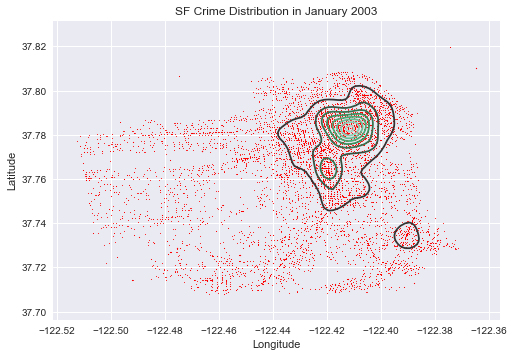

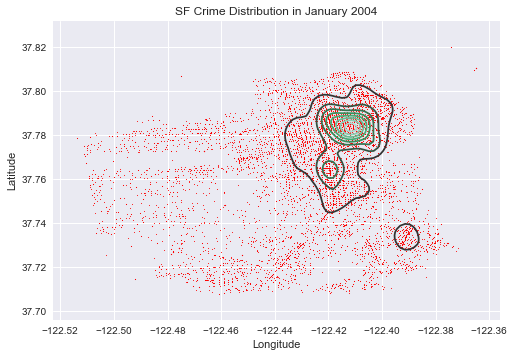

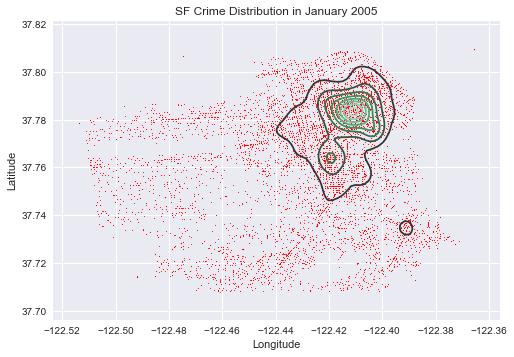

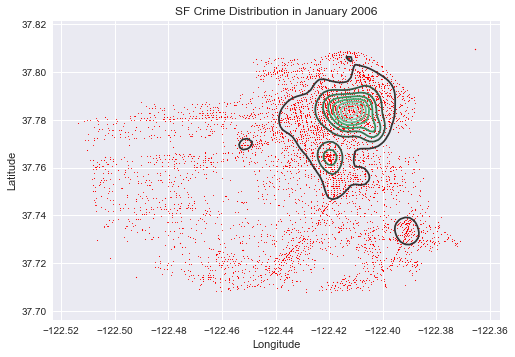

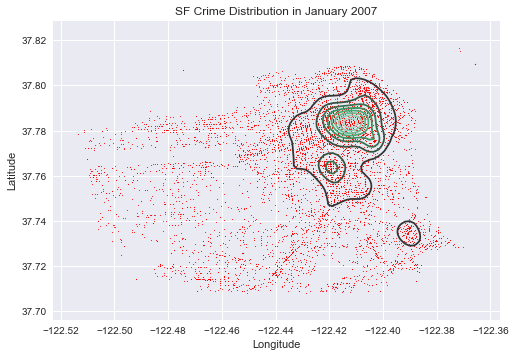

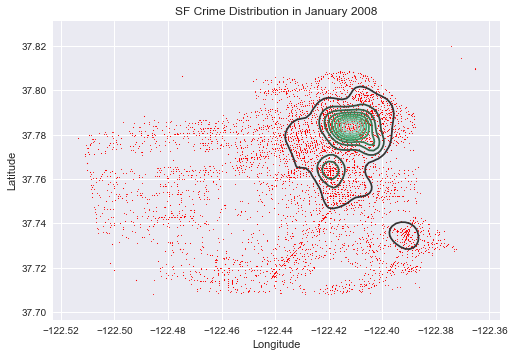

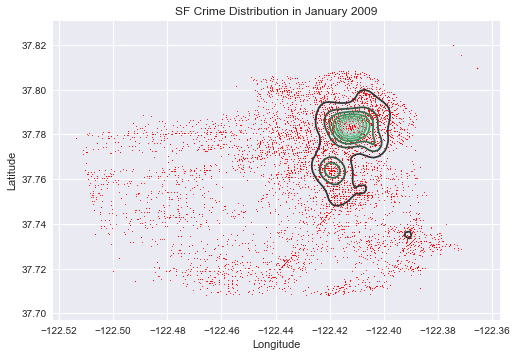

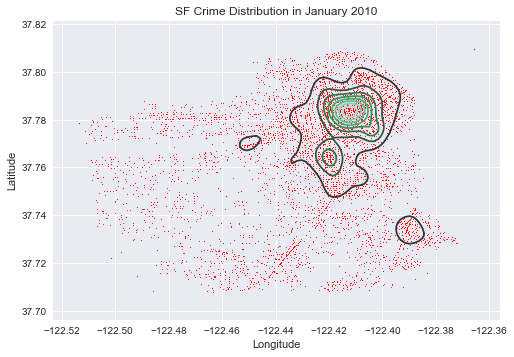

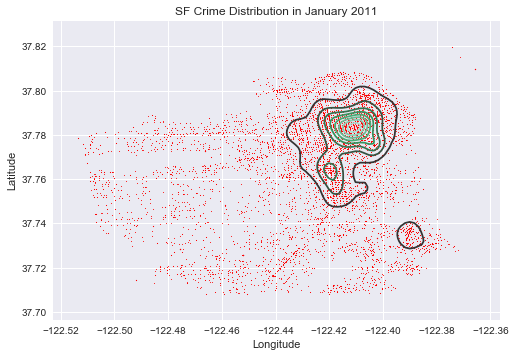

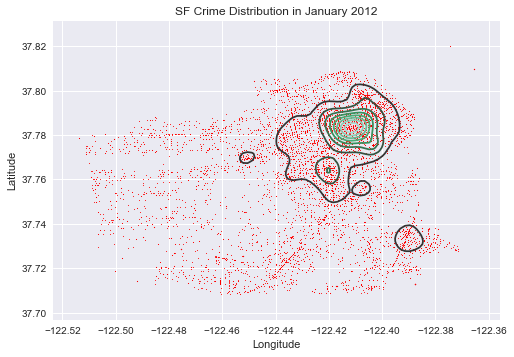

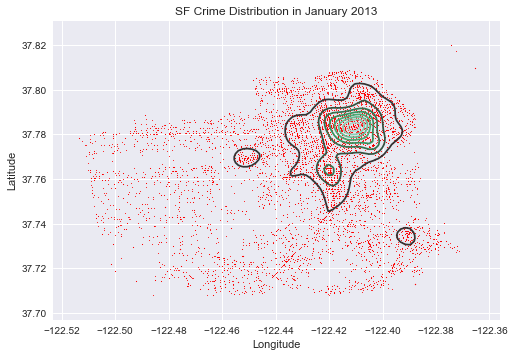

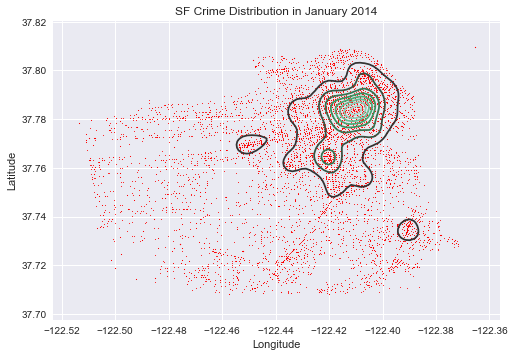

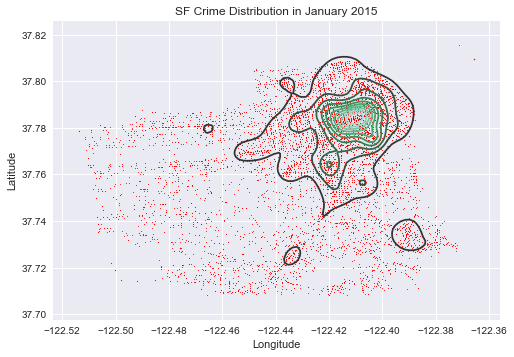

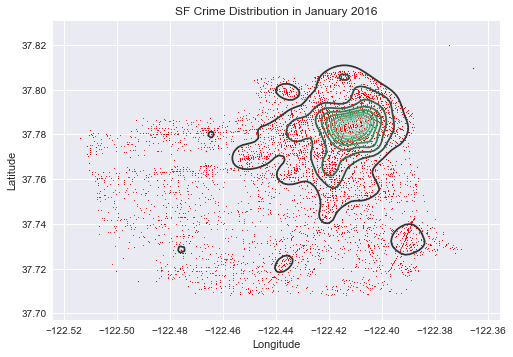

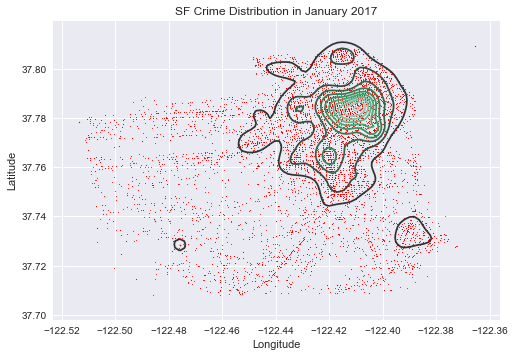

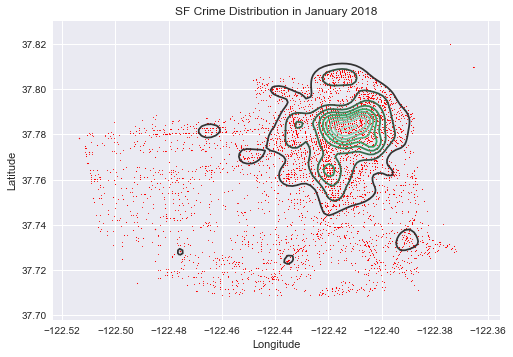

In [18]:
for yr in range(2003, 2019): 
    df_jan = df_new[(df_new['Date'] < str(yr) + '-02') & (df_new['Date'] > str(yr-1) + '-12-31')]
    fig = plt.figure()
    plt.title('SF Crime Distribution in January ' + str(yr))
    plt.scatter(df_jan.X, df_jan.Y, s = 0.5, c = 'r')
    sns.kdeplot(df_jan.X, df_jan.Y)
    sns.plt.xlabel('Longitude')
    sns.plt.ylabel('Latitude')
    plt.show()

So it looks like it the north-eastern part of SF has always been the most dangerous area since 2003. In addition, the contours show that the distribution of crimes around this area has expanded a bit toward its west and south sides since 2015.

## Time Series

Before we start the analysis, we should check what time span this dataset covers exactly.

In [19]:
print "The first date:", df.Date.min()

The first date: 2003-01-01


In [20]:
print "The last date:", df.Date.max()

The last date: 2018-02-18


In [21]:
print "There should be a total of %s days"%((pd.to_datetime('2018-02-18') - pd.to_datetime('2003-01-01')).days + 1)

There should be a total of 5528 days


To produce time series data, we basically have to count the number of reports/rows for each date. If there are no rows for a certain date, we will still have to produce a data point for this date with a count of zero.

In [22]:
time_span = pd.date_range('2003-01-01', '2018-02-18')

# Convert a data frame to time series data
def df_to_TimeSeries(df):
    date = pd.to_datetime(df.Date.value_counts().index)
    index = sorted(date)
    data = df.Date.value_counts().values[np.argsort(date)]
    ts = pd.DataFrame(data = data, index = index, columns = ['count'])
    # if a date within the time span does not exist, fill it in with count = 0
    ts = ts.reindex(time_span, fill_value=0) 
    return ts

Let's first include all the crime categories

In [23]:
all_counts = df_to_TimeSeries(df)

In [24]:
# check if there is any date with count = 0
all_counts[all_counts['count'] == 0]

,count
2009-06-10,0


So 2009-06-10 was a peaceful day? It is probably just due to some mistake made by the police department.

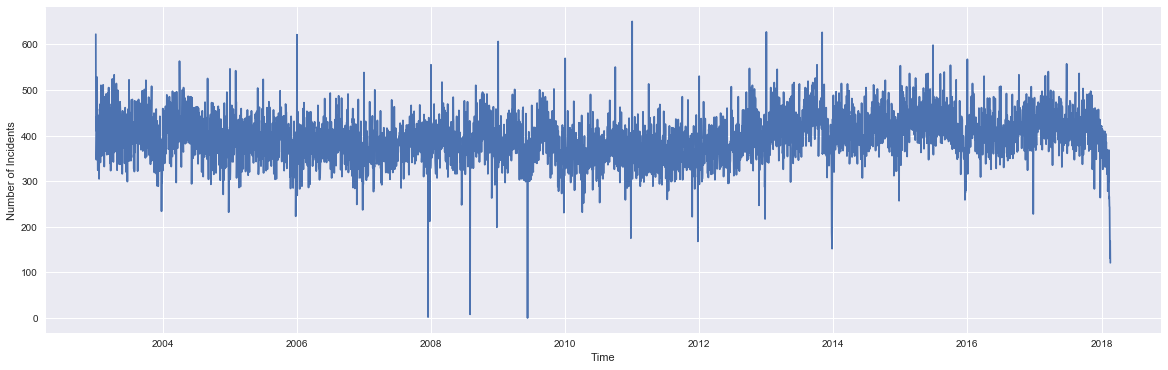

In [25]:
# plot the time series
fig = plt.figure(figsize=(20,6))
all_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of Incidents')
plt.show()

It looks like the crime rate doens't change much over these years! Is it also true for individual categories? Let's try the ``LARCENY/THEFT`` catagory.

In [26]:
df_theft = df.loc[(df['Category'] == 'LARCENY/THEFT'), :]

In [27]:
theft_counts = df_to_TimeSeries(df_theft)

In [28]:
theft_counts[theft_counts['count'] == 0]

,count
2007-12-16,0
2009-06-10,0


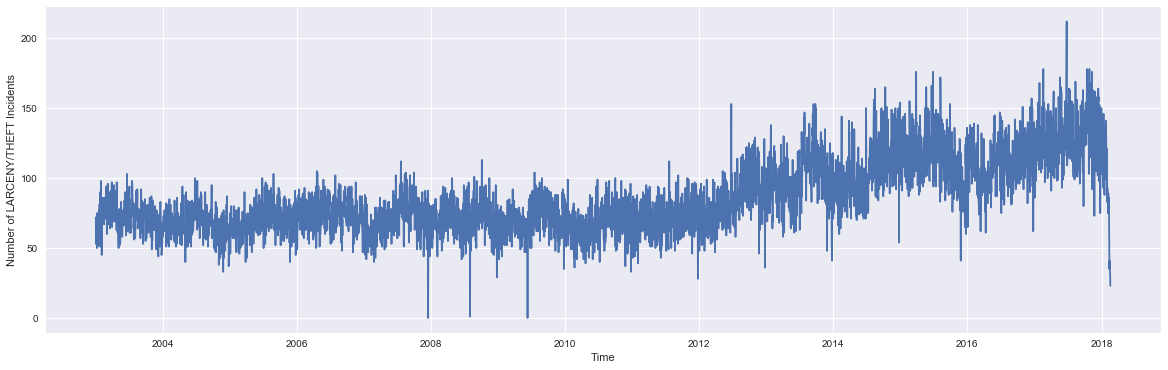

In [29]:
fig = plt.figure(figsize=(20,6))
theft_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of LARCENY/THEFT Incidents')
plt.show()

So the numbers of LARCENY/THEFT Incidents, the most dominant type of crimes, have actually increased since around 2012. I guess this is due to more and more extreme wealth inequality.

Since the total crime rate doens't really change over these years, there should be some categories whose numbers are decreasing. Let's try ``ASSAULT`` this time.

In [30]:
df_assault = df.loc[(df['Category'] == 'ASSAULT'), :]

In [31]:
assault_counts = df_to_TimeSeries(df_assault)

In [32]:
assault_counts[assault_counts['count'] == 0]

,count
2007-12-16,0
2008-08-01,0
2009-06-10,0


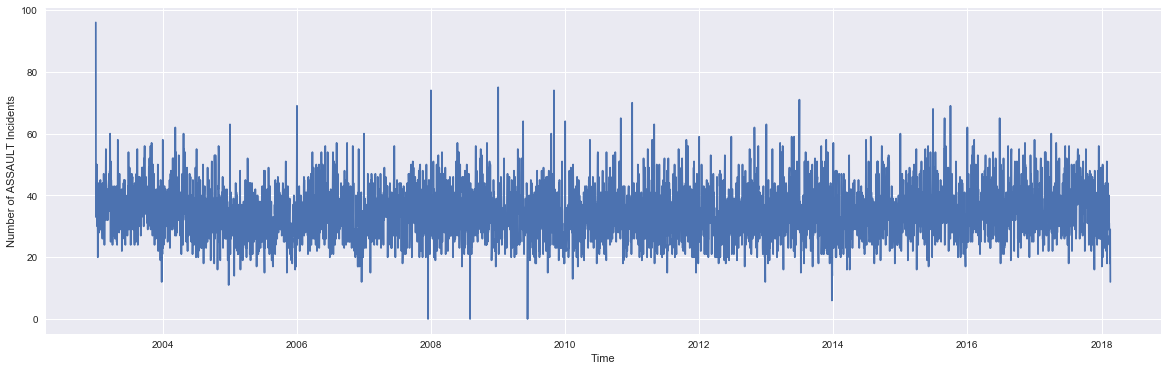

In [33]:
fig = plt.figure(figsize=(20,6))
assault_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of ASSAULT Incidents')
plt.show()

So it actually doesn't change much. How about ``DRUG/NARCOTIC`` ?

In [34]:
df_drug = df.loc[(df['Category'] == 'DRUG/NARCOTIC'), :]

In [35]:
drug_counts = df_to_TimeSeries(df_drug)

In [36]:
drug_counts[drug_counts['count'] == 0]

,count
2007-12-16,0
2008-08-01,0
2009-06-10,0
2017-01-26,0
2017-08-22,0
2017-08-27,0


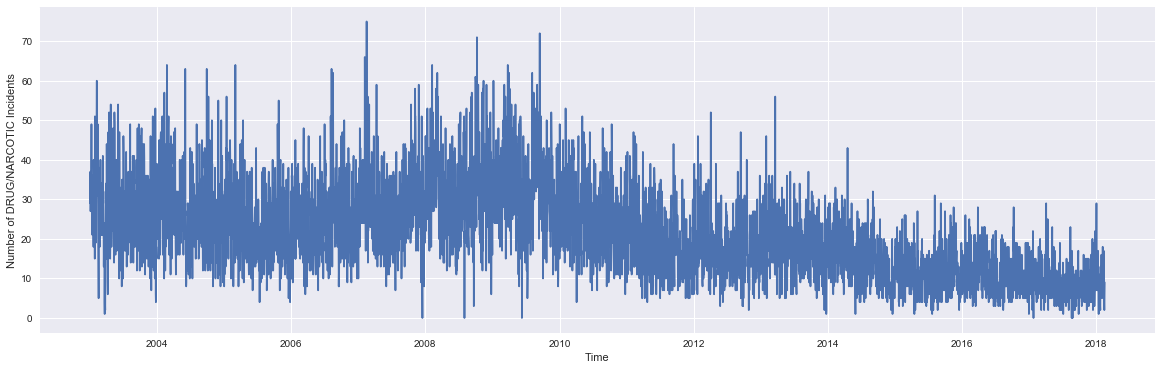

In [37]:
fig = plt.figure(figsize=(20,6))
drug_counts['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of DRUG/NARCOTIC Incidents')
plt.show()

We can see that it has been decreasing and stabilized. The police department probably has a good controll of drug crims over these years.

All of these crime catagories can be further explored and modeled. Here I will attempt to use a ARIMA model to fit the ``LARCENY/THEFT`` data. To reduce the randomness of the data, we can bin the time series into monthly intervals. This strategy is also good if there is a seasonal variation in the data, as 12 months equal a year. Because one year is not a integer of weeks, using weekly intervals for a seasonal ARIMA model does not tend to give a good result.

In [38]:
y = theft_counts.resample('MS').sum()

In [39]:
y.tail()

,count
2017-10-01,4456
2017-11-01,4196
2017-12-01,4022
2018-01-01,3689
2018-02-01,1168


Since the data is only recorded till 2018-02-18, I will remove the data of February 2018.

In [40]:
y = y[:-1]

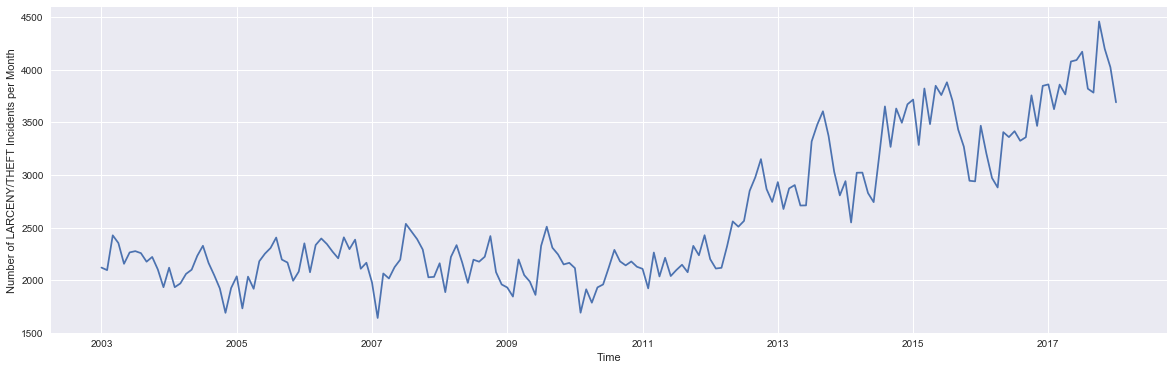

In [41]:
fig = plt.figure(figsize=(20,6))
y['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.show()

Removing the seasonal component from the time series can lead to a clearer relationship between input and output variables. However, identifying whether there is seasonality in the data is quite subjective. Do we see a seasonality here? Well...it's hard to tell. Let's use the ``seasonal_decompose`` function from ``statsmodels`` to decompose our data into a trend, a seasonal pattern and the residual.

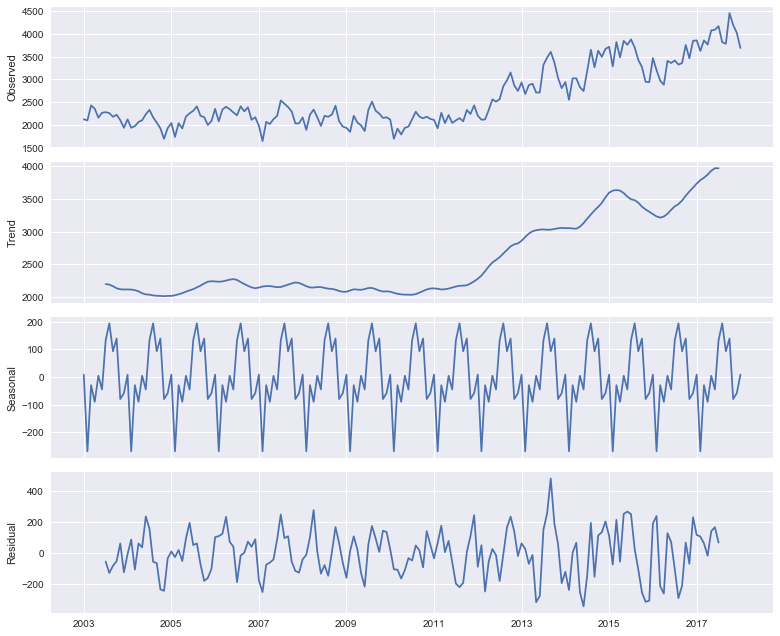

In [42]:
plt.rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

Based one the residual, it seems that using a seasonal period of one year works OK. Therefore, I'll use an seasonal ARIMA model with a seasonal period of one year. I will take the data from the last 12 months as the  testing set.

In [43]:
y_past, y_future = y[:-12], y[-12:]

We can use a grid search to find the best hyperparameters of the model. Here I will only explore 0 or 1 for each of the p, d, q, P, D, and Q. Notice that S = 12 because we've decided to use a seasonal period of one year. We use AIC ([Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)) to evalute the performance of each model.

In [44]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [45]:
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print "(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic)
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 1, 12): AIC = 2720.25796602
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 12): AIC = 2113.78552591
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 0, 12): AIC = 2292.57758692
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 0, 1, 12): AIC = 2263.40319174
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 12): AIC = 2125.09298993
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 1, 12): AIC = 2111.00440074
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 0, 12): AIC = 2893.65529017
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 0, 1, 12): AIC = 2542.28469745
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 0, 12): AIC = 2186.17961278
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 12): AIC = 2014.13348536
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 0, 12): AIC = 2211.43182017
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 0, 1, 12): AIC = 2154.46053608
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 12): AIC = 2036.04290666
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 1, 12): AIC = 2009.46613103
(p,d,q,P,D,Q,S) = (0, 1, 0, 0, 0, 1, 12): AIC = 2099.08750119
(p,d,q,P,D,Q,S) = (0, 1, 0, 0, 1, 1, 12): AIC = 1908.07234094
(p,d,q,P

In [46]:
print "Best (p,d,q,P,D,Q,S) =", param

Best (p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 1, 12)


So the best model is now chosen, and we can see its best-fitted parameters below.

In [47]:
results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6586,0.150,4.389,0.000,0.364,0.953
ma.L1,-0.8460,0.108,-7.808,0.000,-1.058,-0.634
ma.S.L12,-0.9874,0.703,-1.404,0.160,-2.365,0.391
sigma2,2.907e+04,1.92e+04,1.514,0.130,-8555.421,6.67e+04


We can use the ``plot_diagnostics`` method of the model to evaluate the fitting result based on the residuals.

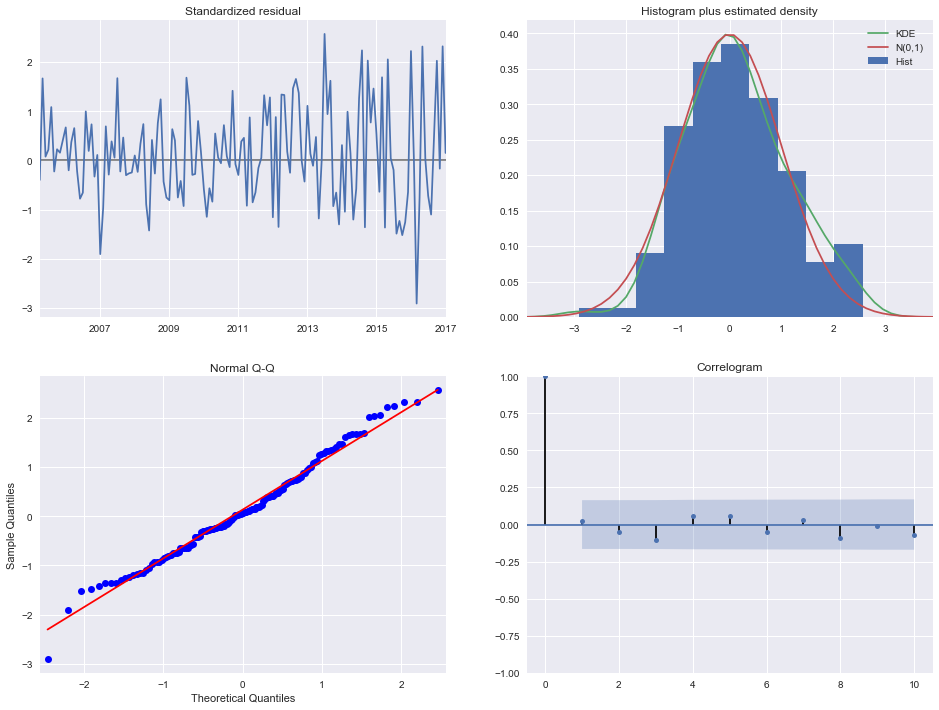

In [48]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

These show that the residuals are close to a normal distribution with zero-mean, and are uncorrelated with each other.

In our ARIMA model, we only take a first-order difference, so we should check weather it is enough to make the time series become stationary. We can use a [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to do this.

In [49]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y['count'].values[1:])
print "-- Before taking the difference --"
print "ADF Statistic:", result[0]
print "p-value:", result[1]

diff = y.diff()
result = adfuller(diff['count'].values[1:])
print "-- After taking the difference --"
print "ADF Statistic:", result[0]
print "p-value:", result[1]

-- Before taking the difference --
ADF Statistic: 0.014323865464669547
p-value: 0.9597007505099246
-- After taking the difference --
ADF Statistic: -4.0551302532225435
p-value: 0.001147811595785975


We see that the p-value becomes close to zero after taking the difference just once, which rejects the null hypothesis of nonstationarity. 

Lastly, we can visually compare the observed time series and the model.

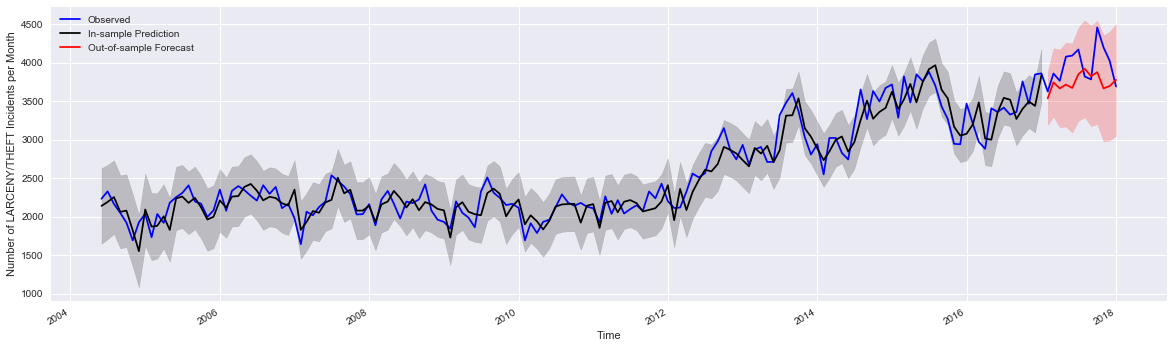

In [50]:
# neglect the beginning of the time series, where the model hasn't converged
pred = results.get_prediction(start = y_past['2004-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=12) # forecast for the next 12 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y['2004-06':].index, y['2004-06':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

We do can see a discrepancy between the observed values and the model for the testing data. However, they are still within a 95% confidence interval of the model prediction.